# Project 4: West Nile Virus Prediction
   ---
  *By Ethan Koh,
      Grace Chia,
      Jocelyn Pok,
      Randy Neo,                    5 June 2020*

# Problem Statement
Find predicted probability that West Nile Virus is present and the observed outcomes.
The city can target mosquito-spraying efforts towards areas that pose the greatest risk, mitigating the potential of another outbreak.Resources can be more efficiently and effectively allocate towards preventing residents’ exposure and transmission of the virus.<br/>
This project is a challenge from https://www.kaggle.com/c/predict-west-nile-virus/overview. <br/>
The models are evaluated on area under the ROC curve between the predicted probability that West Nile Virus is present and the observed outcomes.

# Background

West Nile Virus <sup>1</sup> is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.<br/>
In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.<br/>
Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.<br/>
Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

# Executive Summary

# Data Set

- **Map Data**<br/>
The map files mapdata_copyright_openstreetmap_contributors.rds and mapdata_copyright_openstreetmap_contributors.txt are from Open Streetmap and are primarily provided for use in visualizations.
- **Weather Data** <br/>
From NOAA of the weather conditions of 2007 to 2014, during the months of the tests.  <br/>
Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level <br/>
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level. <br/>
Column descriptions in noaa_weather_qclcd_documentation.pdf. 
- **Spray Data**<br/>
GIS data of spraying efforts in 2011 and 2013 to reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 
- **Train and Test data**<br/>
The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008, 2010, 2012, and 2014.

|Feature|Description|
|---|---|
|Id| the id of the record|
|Date| date that the WNV test is performed|
|Address| approximate address of the location of trap. This is used to send to the GeoCoder |
|Species| the species of mosquitos|
|Block| block number of address|
|Street| street name|
|Trap| Id of the trap|
|AddressNumberAndStreet|approximate address returned from GeoCoder|
|Latitude, Longitude| Latitude and Longitude returned from GeoCoder|
|AddressAccuracy| accuracy returned from GeoCoder|
|NumMosquitos| number of mosquitoes caught in this trap|
|WnvPresent|whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present|

- **Sample Submission**<br/>
A sample submission file in the correct format.

# Content

- Mount Drive
- Import Libraries
- Load Data
- Data Cleaning 
- Feature Engineering
- EDA
- Modeling
- Model Evaluation
- Prepare Test Set
- Cost Benefit Analysis
- Conclusion and Recommendations
- Sources

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier

import plotly.express as px # Install plotly using 'conda install -c plotly plotly'
import geopy.distance # Install geopy using 'conda install -c conda-forge geopy'

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

The train and test data sets contain information from mosquito traps around Chicago, with date, location, and species data for each. The train data set has two additional features compared to the test data set - the number of mosquitoes and whether West Nile Virus is present.

In [0]:
# Read in train dataset and parse dates
train = pd.read_csv('/content/drive/My Drive/DSI14 p4/assets/train.csv', parse_dates=['Date'])

In [4]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [5]:
# No null values for train
# Correct datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [6]:
# Display train shape
train.shape

(10506, 12)

In [0]:
# Read in spray dataset and parse dates
spray = pd.read_csv('/content/drive/My Drive/DSI14 p4/assets/spray.csv', parse_dates=['Date'])

In [8]:
# Display top 5 spray data
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [9]:
# Some null values in the Time column
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Time       14251 non-null  object        
 2   Latitude   14835 non-null  float64       
 3   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [10]:
# Display spray shape
spray.shape

(14835, 4)

In [0]:
# Read in weather dataset and parse dates
weather = pd.read_csv('/content/drive/My Drive/DSI14 p4/assets/weather.csv', parse_dates=['Date'])

In [12]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [13]:
# Some of the datatypes like Tavg and AvgSpeed should be numeric, but they are appearing as object types
# We will need to amend this during data cleaning
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [14]:
# display weather shape
weather.shape

(2944, 22)

In [0]:
# Read in test dataset and parse dates
test = pd.read_csv('/content/drive/My Drive/DSI14 p4/assets/test.csv', parse_dates=['Date'])

In [16]:
# Display top 5 test data
test.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [17]:
# No null values for Test set
# Correct datatypes
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


In [18]:
# Display test shape
test.shape

(116293, 11)

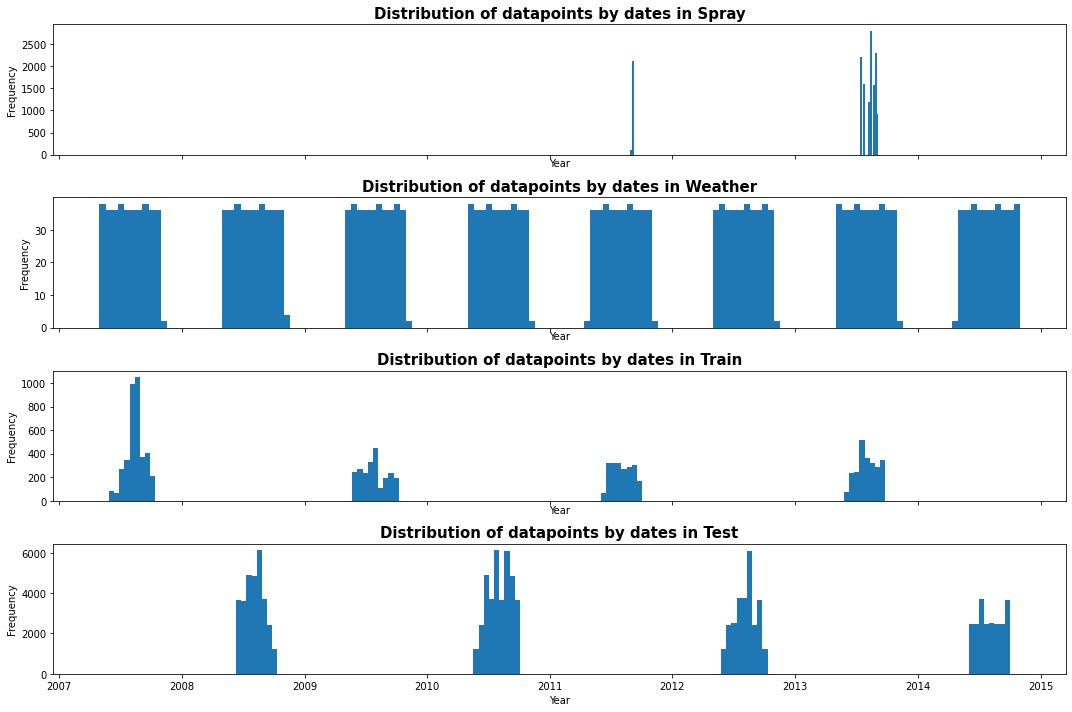

In [19]:
# Plot histogram subplots to compare the date range across the 4 data sets
fig, ax = plt.subplots(4,1, figsize=(15,10), sharex=True)

df_list = [spray, weather, train, test] # List of our dataframes
title_list = ['Spray', 'Weather', 'Train', 'Test']

for i, df in enumerate(df_list):
    ax[i].hist(df['Date'], bins=150)
    ax[i].set_title('Distribution of datapoints by dates in ' + str(title_list[i]), size=15, weight='bold')
    ax[i].set_ylabel('Frequency')
    ax[i].set_xlabel('Year')

plt.tight_layout()

Spray data is rather limited, with only 10 days of spraying in 2011 and 2013. Weather data is provided for the weather conditions of 2007-2014, during the months of the train and test data sets.
Training data set contains the odd-numbered years, 2007, 2009, 2011 and 2013. On the other hand, the test set for prediciton consists of the even-numbered years, 2008, 2010, 2012 and 2014. There is no indication that this is the complete spray data for each year.

# Data Cleaning

## Data Cleaning: Weather

The weather data has some null values (represented by 'M') and some trace values(represented by 'T). There are also features that are not relevant and can be dropped (e.g. 'SnowFall'). There are also many columns that are of object data types that will need to be converted to float and integer type.

In [0]:
# Correct missing values
for col in weather.columns:
    # 'M' and '-' are missing values, we will replace this will NaN
    weather[col].replace('M', np.nan, inplace=True)
    weather[col].replace('-', np.nan, inplace=True)
    # The blank in 'CodeSum' represents 'Moderate'
    weather[col].replace(" ", 'Moderate',inplace=True)
    # 'T' represents the Trace amount of precipitation, which is 0.005
    weather[col].replace('  T', 0.005, inplace=True)

In [21]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,Moderate,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,NaN,NaN,Moderate,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,NaN,NaN,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,Moderate,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9


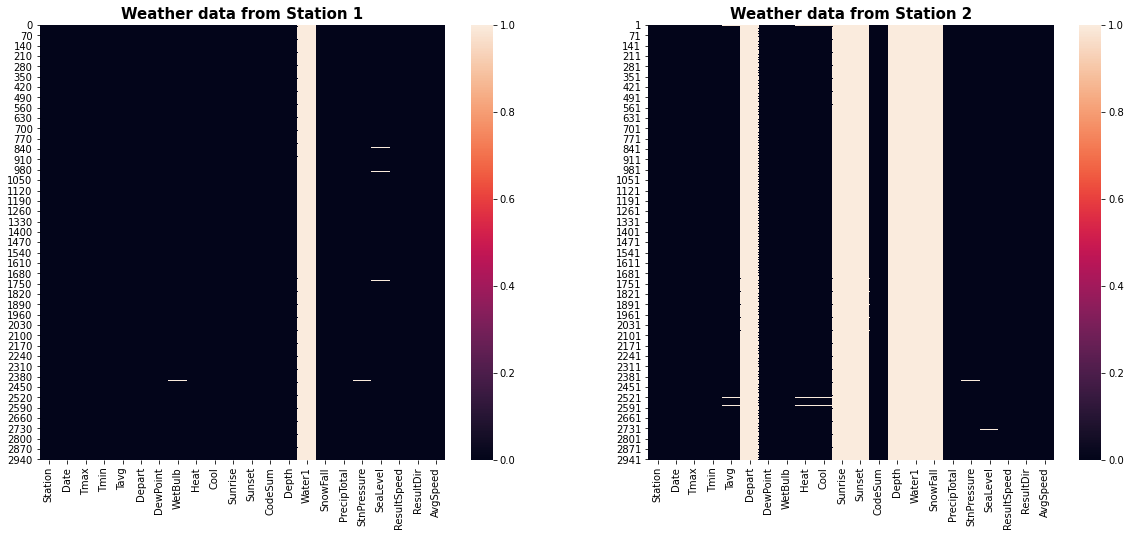

In [22]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

# Plot heatmap of missing values in Station 1
sns.heatmap(weather[weather['Station']==1].isnull(), ax=ax[0])
ax[0].set_title('Weather data from Station 1', fontsize=15, fontweight='bold')

# Plot heatmap of missing values in Station 2
sns.heatmap(weather[weather['Station']==2].isnull(), ax=ax[1])
ax[1].set_title('Weather data from Station 2', fontsize=15, fontweight='bold');

There are a couple of null values in the weather dataset, largely a result of the missing values from Station 2. The EDAs in the next section show that the largest WNV hotspot in 2011 and 2013 is very close to Station 1. Furthermore, as the variance between weather stations is small, there will not be any significant impact from just using one weather station's values. 

In the event that there are missing values in Station 1, we will impute these with Station 2's. Columns with a lot of null values or 0 values like 'Depth', 'Water1', 'SnowFall', will be dropped.

In [0]:
# Fill missing Tavg values by taking the average of Tmax and Tmin
weather['Tavg'].fillna(((weather['Tmax'] + weather['Tmin'])/2),inplace=True)

In [0]:
# Convert Tavg to float type
weather['Tavg'] = weather['Tavg'].astype('float')

In [25]:
# Check for null values in WetBulb
weather[weather['WetBulb'].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
848,1,2009-06-26,86,69,78.0,7,60,NaN,0,13,0418,1931,Moderate,0,NaN,0.0,0.00,NaN,29.85,6.4,4,8.2
2410,1,2013-08-10,81,64,73.0,0,57,NaN,0,8,0454,1900,Moderate,0,NaN,0.0,0.00,NaN,30.08,5.3,5,6.5
2412,1,2013-08-11,81,60,71.0,-2,61,NaN,0,6,0455,1859,RA,0,NaN,0.0,0.01,29.35,30.07,2.0,27,3.0
2415,2,2013-08-12,85,69,77.0,NaN,63,NaN,0,12,NaN,NaN,RA,NaN,NaN,NaN,0.66,29.27,29.92,4.5,26,7.7


In [0]:
# Fill station 1's wetbulb with station 2's
weather.loc[848,'WetBulb'] = weather.loc[849,'WetBulb']
weather.loc[2410,'WetBulb'] = weather.loc[2411,'WetBulb']
weather.loc[2412,'WetBulb'] = weather.loc[2413,'WetBulb']

In [27]:
weather[weather['StnPressure'].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86,68,77.0,NaN,53,62,0,12,NaN,NaN,Moderate,NaN,NaN,NaN,0.00,NaN,NaN,7.0,5,NaN
848,1,2009-06-26,86,69,78.0,7,60,67,0,13,0418,1931,Moderate,0,NaN,0.0,0.00,NaN,29.85,6.4,4,8.2
2410,1,2013-08-10,81,64,73.0,0,57,63,0,8,0454,1900,Moderate,0,NaN,0.0,0.00,NaN,30.08,5.3,5,6.5
2411,2,2013-08-10,81,68,75.0,NaN,55,63,0,10,NaN,NaN,Moderate,NaN,NaN,NaN,0.00,NaN,30.07,6.0,6,7.4


In [0]:
# Fill station 1's StnPressure with station 2's
weather.loc[848,'StnPressure'] = weather.loc[849,'StnPressure']

# Both station and 2 StnPressure is NA for row index 2410 and 2411. We will fill station 1's StnPressure with the prior day's value
weather.loc[2410,'StnPressure'] = weather.loc[2408,'WetBulb']

In [29]:
# Check for null values in SeaLevel
weather[weather['SeaLevel'].isnull()]

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86,68,77.0,NaN,53,62,0,12,NaN,NaN,Moderate,NaN,NaN,NaN,0.00,NaN,NaN,7.0,5,NaN
832,1,2009-06-18,80,61,71.0,1,63,67,0,6,0416,1929,RA BR,0,NaN,0.0,0.12,29.08,NaN,6.7,16,7.9
994,1,2009-09-07,77,59,68.0,1,59,62,0,3,0523,1817,BR,0,NaN,0.0,0.00,29.39,NaN,5.8,3,4.0
1732,1,2011-09-08,75,57,66.0,0,53,59,0,1,0524,1815,RA,0,NaN,0.0,0.005,29.34,NaN,13.0,2,13.4
1745,2,2011-09-14,60,48,54.0,NaN,45,51,11,0,NaN,NaN,RA BR HZ FU,NaN,NaN,NaN,0.005,29.47,NaN,6.0,32,NaN
1756,1,2011-09-20,74,49,62.0,0,54,58,3,0,0537,1753,MIFG BCFG BR,0,NaN,0.0,0.00,29.26,NaN,7.3,18,7.3
2067,2,2012-08-22,84,72,78.0,NaN,51,61,NaN,NaN,NaN,NaN,Moderate,NaN,NaN,NaN,0.00,29.39,NaN,4.7,19,NaN
2090,1,2012-09-03,88,71,80.0,12,70,73,0,15,0519,1824,BR,0,NaN,0.0,0.00,29.17,NaN,4.6,6,4.4
2743,2,2014-07-23,76,64,70.0,NaN,56,61,0,5,NaN,NaN,Moderate,NaN,NaN,NaN,0.00,29.47,NaN,16.4,2,16.7


In [0]:
# Fill station 1's missing SeaLevel values using station 2's
weather['SeaLevel'].fillna(method='bfill', inplace=True)

In [0]:
# Drop columns with a lot of null values and 0s since they will not be useful in modeling
weather.drop(['Depth','Water1','SnowFall'], axis=1, inplace=True)

# Drop CodeSum too as it just a descriptor for the weather
weather.drop(['CodeSum'], axis=1, inplace=True)

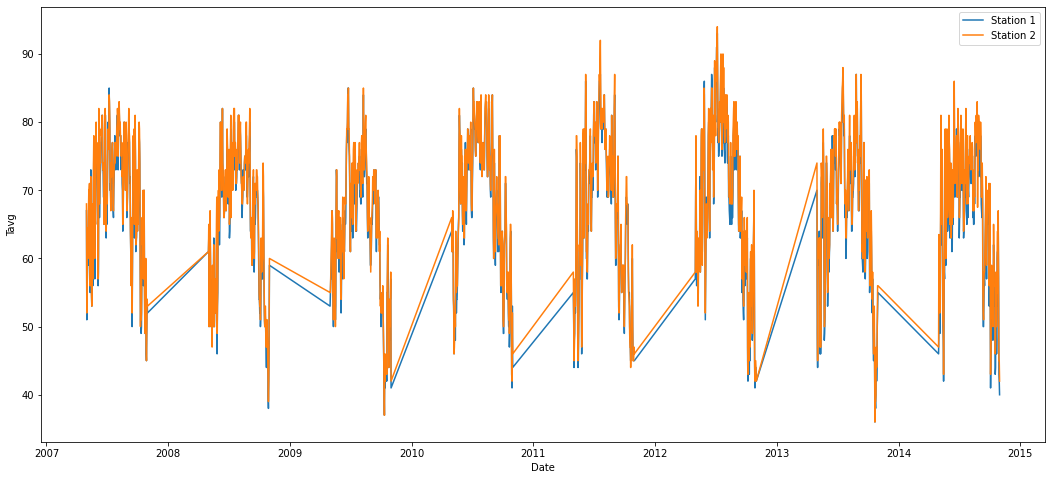

In [32]:
# Tavg for station 1 and 2 are very similar over the years 
# As the variance between weather stations is very small, we can just using station 1's weather data for modeling.
plt.figure(figsize=(18,8))
sns.lineplot(x='Date', y='Tavg', data=weather[weather['Station']==1], label='Station 1')
sns.lineplot(x='Date', y='Tavg', data=weather[weather['Station']==2], label='Station 2');

In [0]:
# Station 1 will be used for modeling as it is nearer to the WNV hotspot in the later years and variance between the two stations is minute
weather = weather.drop(weather[weather['Station'] == 2].index)

In [0]:
# Convert values to float or int
cols_to_float = ['Depart', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultDir', 'AvgSpeed']
for col in cols_to_float:
    weather[col] = weather[col].astype(float)

cols_to_int = ['Sunrise', 'Sunset']
for col in cols_to_int:
    weather[col] = weather[col].astype(int)

In [35]:
# Check that there are no more null values
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [36]:
# Check that data types are correct - only float, int and datetime
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      1472 non-null   int64         
 1   Date         1472 non-null   datetime64[ns]
 2   Tmax         1472 non-null   int64         
 3   Tmin         1472 non-null   int64         
 4   Tavg         1472 non-null   float64       
 5   Depart       1472 non-null   float64       
 6   DewPoint     1472 non-null   int64         
 7   WetBulb      1472 non-null   float64       
 8   Heat         1472 non-null   float64       
 9   Cool         1472 non-null   float64       
 10  Sunrise      1472 non-null   int64         
 11  Sunset       1472 non-null   int64         
 12  PrecipTotal  1472 non-null   float64       
 13  StnPressure  1472 non-null   float64       
 14  SeaLevel     1472 non-null   float64       
 15  ResultSpeed  1472 non-null   float64       
 16  Result

In [37]:
# Display top 5 rows in weather
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,448,1849,0.000,29.10,29.82,1.7,27.0,9.2
2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,447,1850,0.000,29.38,30.09,13.0,4.0,13.4
4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,446,1851,0.000,29.39,30.12,11.7,7.0,11.9
6,1,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,444,1852,0.005,29.31,30.05,10.4,8.0,10.8
8,1,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,443,1853,0.005,29.40,30.10,11.7,7.0,12.0


## Data Cleaning: Train

In [0]:
# Drop columns which are related to Address. We will use Latitude and Longitude instead since it is more accurate.
train.drop(['Address', 'Block', 'AddressNumberAndStreet', 'AddressAccuracy'], axis=1, inplace=True)

In [39]:
# Check that those columns have been dropped
train.head()

,Date,Species,Street,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
0,2007-05-29,CULEX PIPIENS/RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,N MANDELL AVE,T007,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,W FOSTER AVE,T015,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,W FOSTER AVE,T015,41.974089,-87.824812,4,0


#Feature Engineering

## Feature Engineering: Train

Warm weather conditions in the summer months are more likely to promote WNV. As such, we will breakdown the Date column into more granularity - day, week, month and year. This will help us to identify any effects of seasonality.

In [0]:
# Breakdown the Date into day, week, month and year to account for the seasonality effect of mosquito breeding and WNV
train['day'] = train['Date'].dt.dayofyear
train['week'] = train['Date'].dt.week
train['month'] = train['Date'].dt.month
train['year'] = train['Date'].dt.year

In [41]:
# Sense check new columns
train[['Date','day','week','month','year']].head()

,Date,day,week,month,year
0,2007-05-29,149,22,5,2007
1,2007-05-29,149,22,5,2007
2,2007-05-29,149,22,5,2007
3,2007-05-29,149,22,5,2007
4,2007-05-29,149,22,5,2007


## Feature Engineering: Weather

The weather dataset represents the bulk of the data available for both train and test data sets, and feature engineering will primarily take place there. Features such as rolling averages, sunlight duration and categorizing light and heavy rain days will be explored. 

In [0]:
# Create a column for sunlight duration in a day
weather['day_length'] = weather['Sunset'] - weather['Sunrise']

# Drop sunrise and sunset
weather.drop(['Sunset','Sunrise'], axis=1, inplace=True)

Understanding the conditions preferable for mosquito population growth can help us gain insights from the weather condition. Bodies of water are ideal breeding spots for mosquitos, as such the amount of precipitation will be investigated. Features factoring in the frequency of light rain and heavy rain in the last 14 days are generated to analyse the mosquito population when there was rain. 

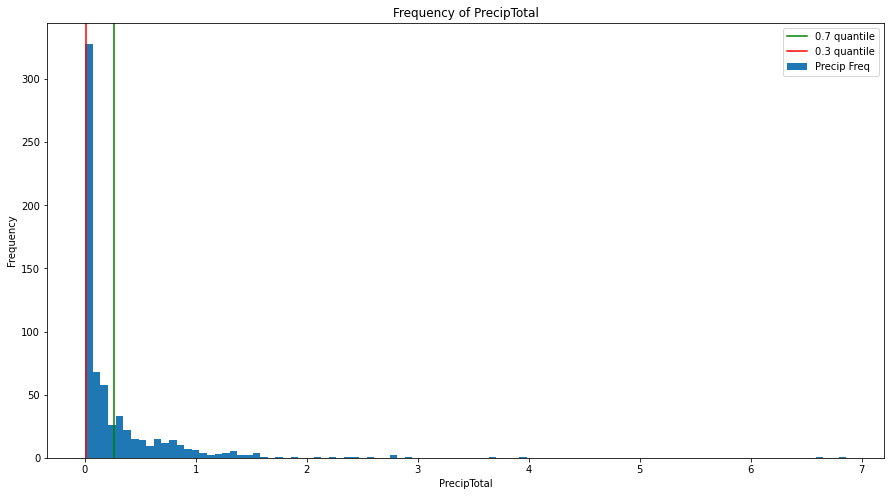

In [43]:
# Plot to decide what quantile to use to constitute heavy rain and light rain 
plt.figure(figsize=(15,8))
plt.hist(weather[weather['PrecipTotal'] > 0]['PrecipTotal'],bins=100)
plt.axvline(weather[weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(0.7),color='green')
plt.axvline(weather[weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(0.3),color='red')
plt.xlabel('PrecipTotal')
plt.ylabel('Frequency')
plt.title('Frequency of PrecipTotal')
plt.legend(('0.7 quantile',
            '0.3 quantile',
            'Precip Freq'));
# There is more meaningful split when used 70 and 30 for heavy and light rain respectively

In [0]:
# Create columns for light and heavy rain days based on quantile of rainy days
precip_70quantile = weather[weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.7) #heavy rain day defined as 70th quantile or above of rainy days
precip_30quantile = weather[weather['PrecipTotal'] > 0]['PrecipTotal'].quantile(.3) #light rain day defined as 30th quantile or below of rainy days

In [0]:
weather['heavy_rain'] = (weather['PrecipTotal']>precip_70quantile)
weather['light_rain'] = ((weather['PrecipTotal']>0) & (weather['PrecipTotal']<precip_30quantile))

In [0]:
light_rain_col_list = []
heavy_rain_col_list = []
for i in range(1,15):
    weather['light_rain_' + str(i) + '_days_ago'] = weather['light_rain'].shift(periods=i)
    weather['heavy_rain_'+ str(i) + '_days_ago'] = weather['heavy_rain'].shift(periods=i)
    light_rain_col_list.append('light_rain_' + str(i) + '_days_ago')
    heavy_rain_col_list.append('heavy_rain_' + str(i) + '_days_ago')

In [0]:
# Create column that sums up the number of days it rained in the past 14 days 
weather['heavy_rain_last_14_days_count'] = weather[heavy_rain_col_list].sum(axis=1)
weather['light_rain_last_14_days_count'] = weather[light_rain_col_list].sum(axis=1)

In [0]:
# Drop the interim rain features that were used to help engineer 'heavy_rain_last_14_days_count' & 'light_rain_last_14_days_count'
weather = weather.select_dtypes(exclude=['object','bool'])

As the complete life cycle of a mosquito is 10-14 days <sup>2</sup>, we will create rolling averages for some weather variables.

In [0]:
# Create rolling features for the following weather conditions
cols = ['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'day_length']

for col in cols:
    weather[col + '_rolling_14'] = weather[col].rolling(window=14).mean()

In [0]:
# Function to plot time series subplots to look at the seasonlity of weather features
def subplot_rolling(dataframe, yvar, list_of_xvars):
    nrows = int(np.ceil(len(list_of_xvars)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(14,15)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_xvars): # Gives us an index value to get into all our lists
        ax[i].plot(dataframe[yvar],dataframe[column])
        ax[i].plot(dataframe[yvar],dataframe[column].rolling(14).mean()) # Moving average of 14 days
        ax[i].set_xlabel("Date")
        ax[i].set_ylabel(str(column))
    plt.tight_layout()

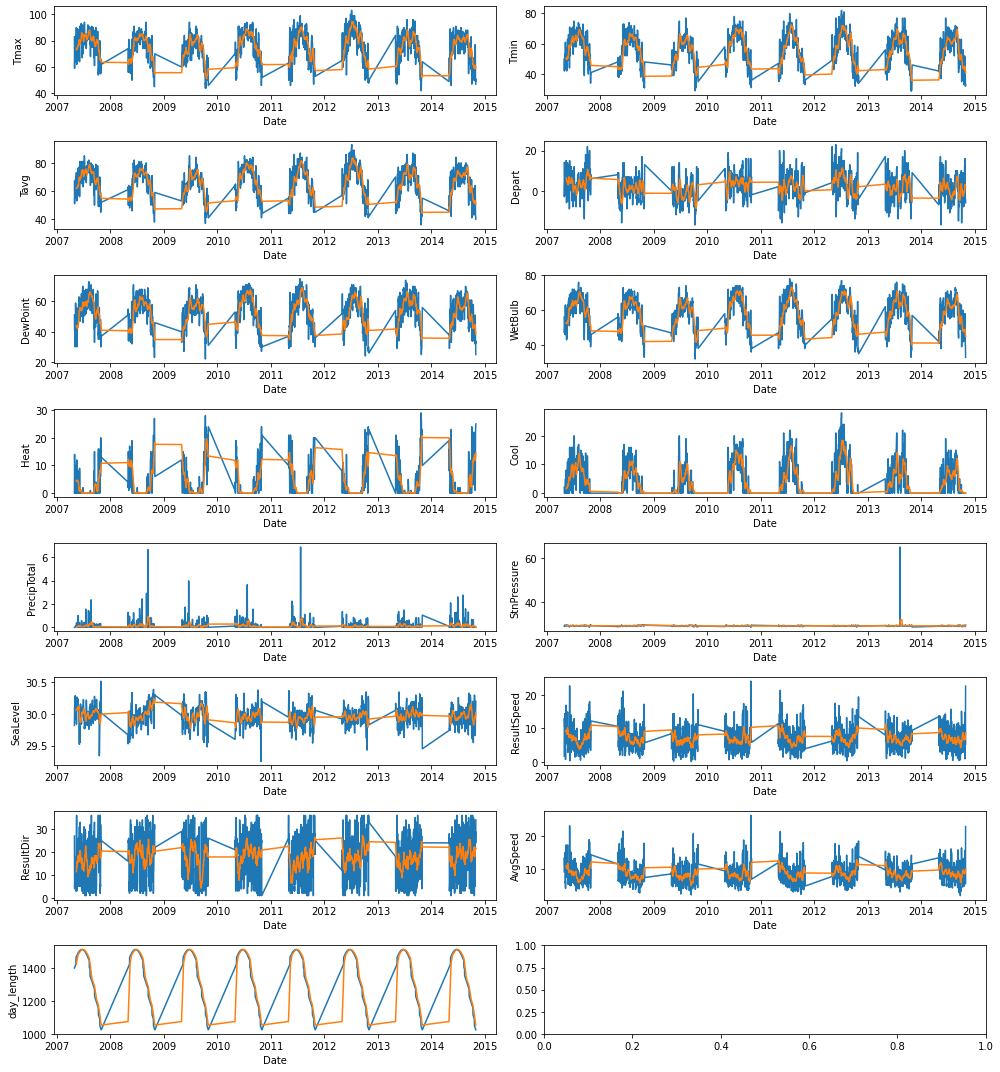

In [51]:
#plot time series subplots to look at the seasonlity of weather features and check for abnormality
subplot_rolling(dataframe=weather,
                   yvar ='Date',
                  list_of_xvars=cols)

# Clear seasonality present. suggest yearly seasonality
# should drop StationPressure above 35. Seems to be unusual. could be due to input error

In [0]:
# Drop 1 row with abnormally high StnPressure
weather.drop(weather[weather['StnPressure']>35].index,inplace=True)

In [0]:
# Merge the train and weather dataframes on the Date column
train_weather = pd.merge(train, weather, on='Date')

In [54]:
# View the first 3 rows of our merged dataframe
train_weather.head(3)

,Date,Species,Street,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,day,week,month,year,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,day_length,heavy_rain_last_14_days_count,light_rain_last_14_days_count,Tmax_rolling_14,Tmin_rolling_14,Tavg_rolling_14,Depart_rolling_14,DewPoint_rolling_14,WetBulb_rolling_14,Heat_rolling_14,Cool_rolling_14,PrecipTotal_rolling_14,StnPressure_rolling_14,SeaLevel_rolling_14,ResultSpeed_rolling_14,ResultDir_rolling_14,AvgSpeed_rolling_14,day_length_rolling_14
0,2007-05-29,CULEX PIPIENS/RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,1,0,149,22,5,2007,1,88,60,74.0,10.0,58,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,1496,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429
1,2007-05-29,CULEX RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,1,0,149,22,5,2007,1,88,60,74.0,10.0,58,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,1496,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429
2,2007-05-29,CULEX RESTUANS,N MANDELL AVE,T007,41.994991,-87.769279,1,0,149,22,5,2007,1,88,60,74.0,10.0,58,65.0,0.0,9.0,0.0,29.39,30.11,5.8,18.0,6.5,1496,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429


## Feature Engineering: Spray

Spray clusters are created and visualized where spraying occurred using DBSCAN. Since the spraying occurs in distance based clusters, DBSCAN was selected to perform the unsupervised clustering. DBSCAN uses two parameters, eps (the minimum distance between two points) and minPoints (the minimum number of points to form a dense region). The Spray clusters are subsequently overlayed on locations with WNV presence.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



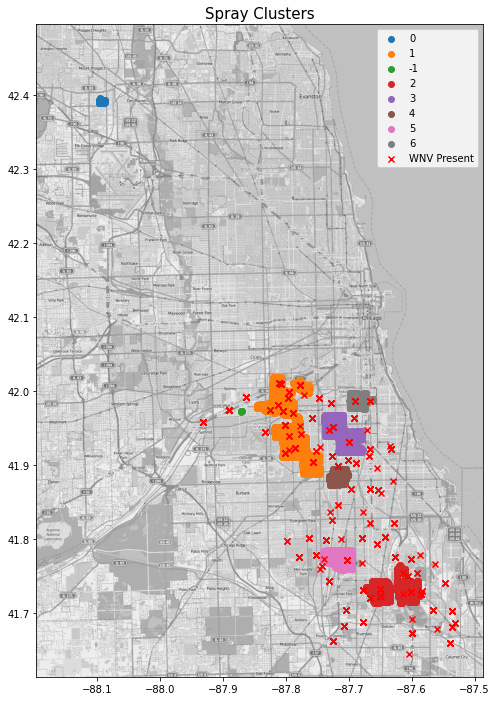

In [55]:
#use DBSCAN to cluster spray data to use to create spray cluster feature
X_spray = spray[['Latitude', 'Longitude']] #isolate lat long data
spray_cluster_model = DBSCAN(eps=.01, min_samples=20).fit(X_spray) #run DBSCAN 
X_spray['cluster'] = spray_cluster_model.labels_ #create cluster feature 
#set dimensions of plot
lon_lat_box_spray = (X_spray['Longitude'].min()-.1, X_spray['Longitude'].max()+.1, X_spray['Latitude'].min()-.1,X_spray['Latitude'].max()+.1)

#create plot of spray clusters, for loop allows for legend to represent clusters 
fig, ax = plt.subplots(figsize=(8,12))
mapdata = np.loadtxt('/content/drive/My Drive/DSI14 p4/assets/mapdata_copyright_openstreetmap_contributors.txt')
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), aspect='auto', extent=lon_lat_box_spray) 

#iterate through each cluster value and plot points in the same figure (maintains lables)
for i in X_spray['cluster'].unique():  
    ax.scatter(X_spray[X_spray['cluster'] == i]['Longitude'], 
               X_spray[X_spray['cluster'] == i]['Latitude'], 
               label=i, marker='o')

#overlay WNV presence
plt.scatter(train_weather[train_weather['WnvPresent'] == 1]['Longitude'], 
            train_weather[train_weather['WnvPresent'] == 1]['Latitude'], 
            marker='x', label='WNV Present', color='r')
plt.legend()
plt.title('Spray Clusters', size=15);

The add_cluster function adds the spray cluster feature using RandomForestClassifier to predict. Features are randomly selected to go into each split. This effectively makes individual decision trees less correlated, which decreases the variance of the predictions after aggregating the different decision trees. 

In [0]:
def add_clusters(df):
    X = X_spray[['Latitude', 'Longitude']]
    y = X_spray['cluster']
    rf1 = RandomForestClassifier()
    fit1 = rf1.fit(X, y)
    df['spray_cluster'] = fit1.predict(df[['Latitude','Longitude']])

    return df

In [0]:
# run function to add cluster which can be thought of as adding spray data 
train_weather = add_clusters(train_weather)

In [58]:
train_weather.shape

(10506, 46)

# EDA

The dataset is imbalanced with WNV presence accounting for only 5% of dataset.

In [59]:
# Highly imbalanced class with WNV presence accounting for only 5% of dataset
train_weather['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

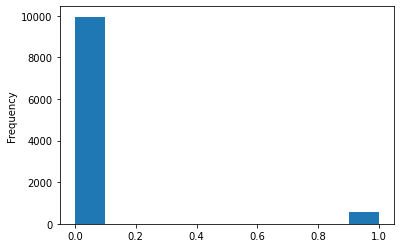

In [60]:
# Visualising the WNV presence in our dataset
train_weather['WnvPresent'].plot(kind='hist');

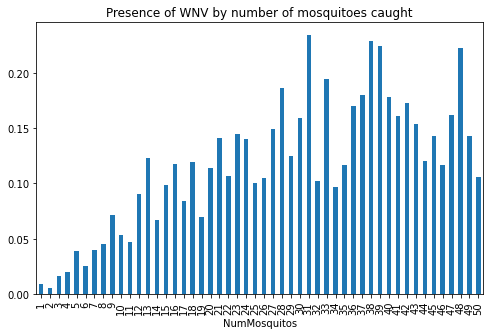

In [61]:
# WNV increases as number of mosquitoes caught increases
plt.figure(figsize=(8,5))
train_weather.groupby('NumMosquitos')['WnvPresent'].mean().plot(kind='bar')
plt.title('Presence of WNV by number of mosquitoes caught');

## Seasonality

In [62]:
## This chart will show that there is a seasonality concern in our dataset 
#(Mosquitoes breeding season vs impact on WnV )

train_by_wnv=pd.DataFrame(train_weather.groupby('Date')[['NumMosquitos','WnvPresent']].sum()).reset_index()

fig = px.line(train_by_wnv, x='Date', y='NumMosquitos',title='By no. of mosquitoes')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)


The mosquito population is at its peak in the month of August. 

In [0]:
# Wrote a function to plot histogram subplots to compare the effects of seasonality
def subplot_histograms(dataframe, yvar, list_of_xvars, list_of_titles, list_of_xlabels, ylabel):
    nrows = int(np.ceil(len(list_of_xvars)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(15,10)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_xvars): # Gives us an index value to get into all our lists
        dataframe.groupby(column)[yvar].mean().plot(kind='bar', ax=ax[i])
        ax[i].set_title(list_of_titles[i])
        ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_ylabel(ylabel)
    plt.tight_layout()

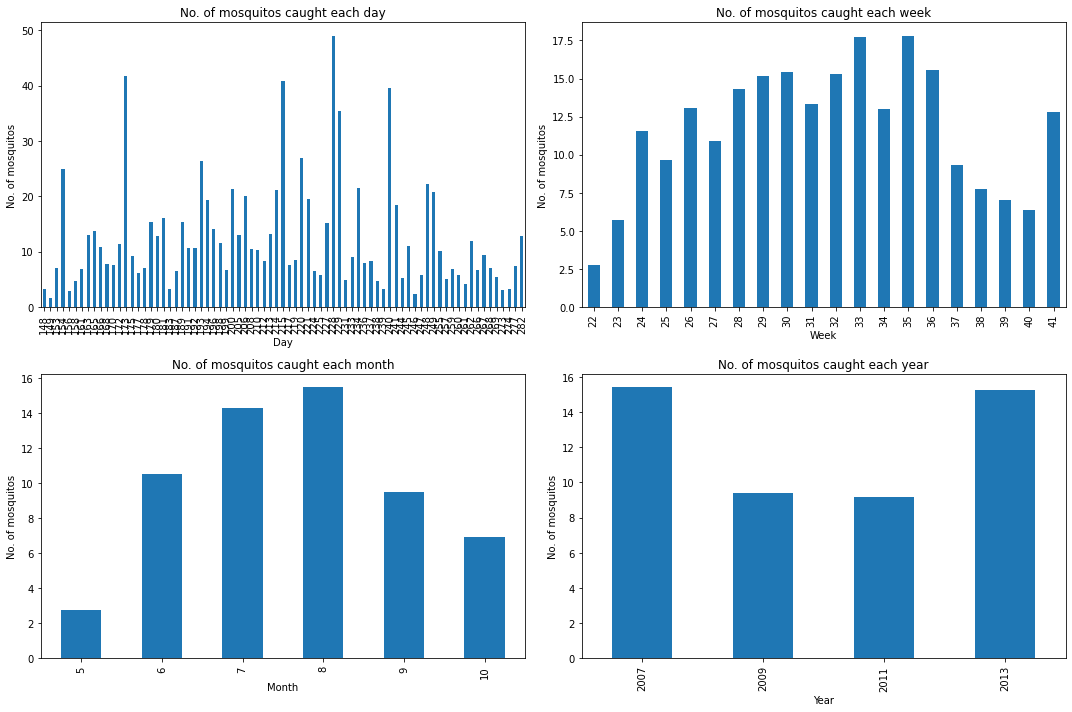

In [64]:
# Comparing the effects of sesonality on no. of mosquitos caught
subplot_histograms(dataframe=train_weather,
                   yvar ='NumMosquitos',
                  list_of_xvars=['day', 'week', 'month', 'year'],
                  list_of_titles=['No. of mosquitos caught each day', 'No. of mosquitos caught each week', 'No. of mosquitos caught each month', 'No. of mosquitos caught each year'],
                  list_of_xlabels=['Day', 'Week', 'Month', 'Year'],
                  ylabel='No. of mosquitos')

In [65]:

fig = px.line(train_by_wnv, x='Date', y='WnvPresent',title='WnvPresent')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

Distribution of WNV presence over the years in the train dataset. 2007 & 2013 have higher incidences of WNV presence.

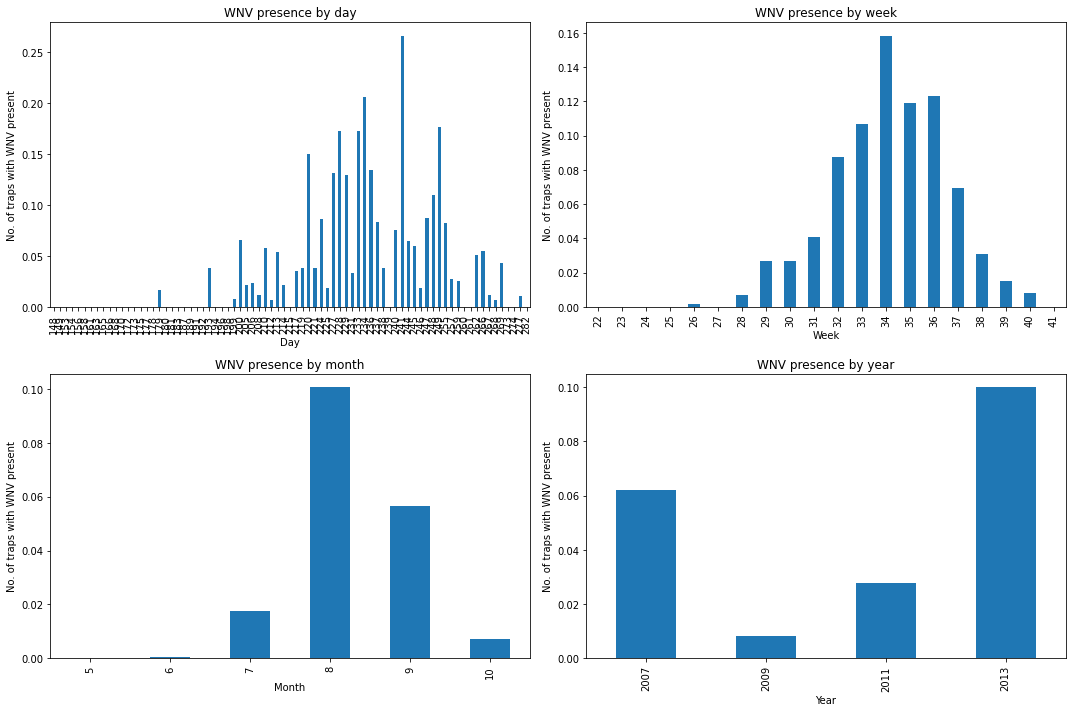

In [66]:
# Comparing the effects of sesonality on presence of WNV
subplot_histograms(dataframe=train_weather,
                   yvar ='WnvPresent',
                   list_of_xvars=['day', 'week', 'month', 'year'],
                   list_of_titles=['WNV presence by day', 'WNV presence by week', 'WNV presence by month', 'WNV presence by year'],
                   list_of_xlabels=['Day', 'Week', 'Month', 'Year'],
                   ylabel='No. of traps with WNV present')

## Ideal Weather Conditions

In [0]:
# Function to plot for number of mosquitos vs rolling variables
def subplot_rolling_14(dataframe, yvar, list_of_xvars):
    nrows = int(np.ceil(len(list_of_xvars)/2)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(14,15)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_xvars): # Gives us an index value to get into all our lists
        ax[i].plot(dataframe[[column,yvar]].groupby([column], as_index=True).sum())
        ax[i].set_xlabel(str(column))
        ax[i].set_ylabel(str(yvar))
    plt.tight_layout()

In [0]:
cols_last_14_days = ['heavy_rain_last_14_days_count',
       'light_rain_last_14_days_count', 'Tavg_rolling_14',
       'ResultSpeed_rolling_14', 'WetBulb_rolling_14', 'Heat_rolling_14',
       'Cool_rolling_14', 'DewPoint_rolling_14', 'PrecipTotal_rolling_14',
       'StnPressure_rolling_14', 'SeaLevel_rolling_14', 'ResultDir_rolling_14',
       'AvgSpeed_rolling_14', 'day_length_rolling_14', 'Tmax_rolling_14',
       'Tmin_rolling_14']

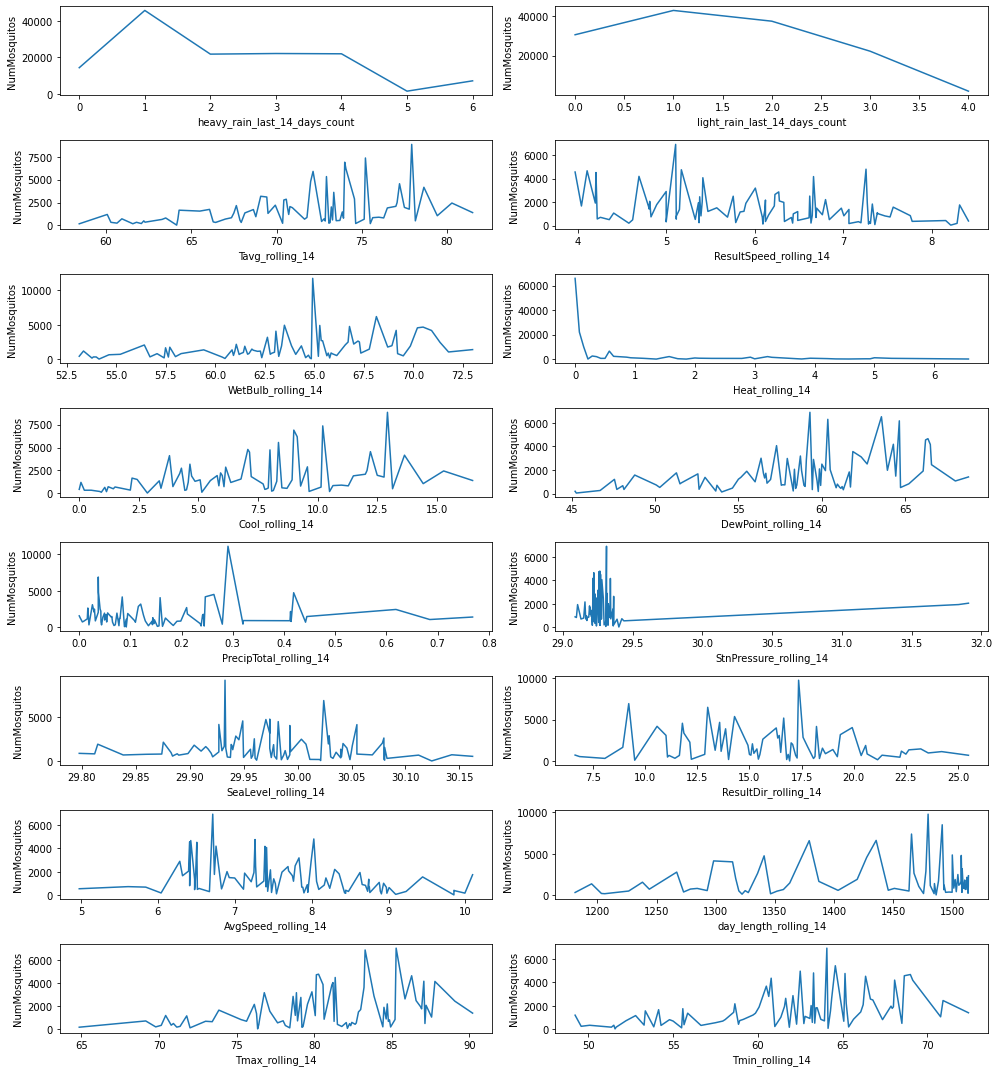

In [69]:
# Plot for number of mosquitos vs rolling variables
subplot_rolling_14(dataframe=train_weather,
                   yvar ='NumMosquitos',
                  list_of_xvars=cols_last_14_days)

# heavy rain counts for ~2-4 times prior to traps provide good habitat conditions for breeding. Of which there is a subsequent dip. Possibly due to the flushing out of these habitats?

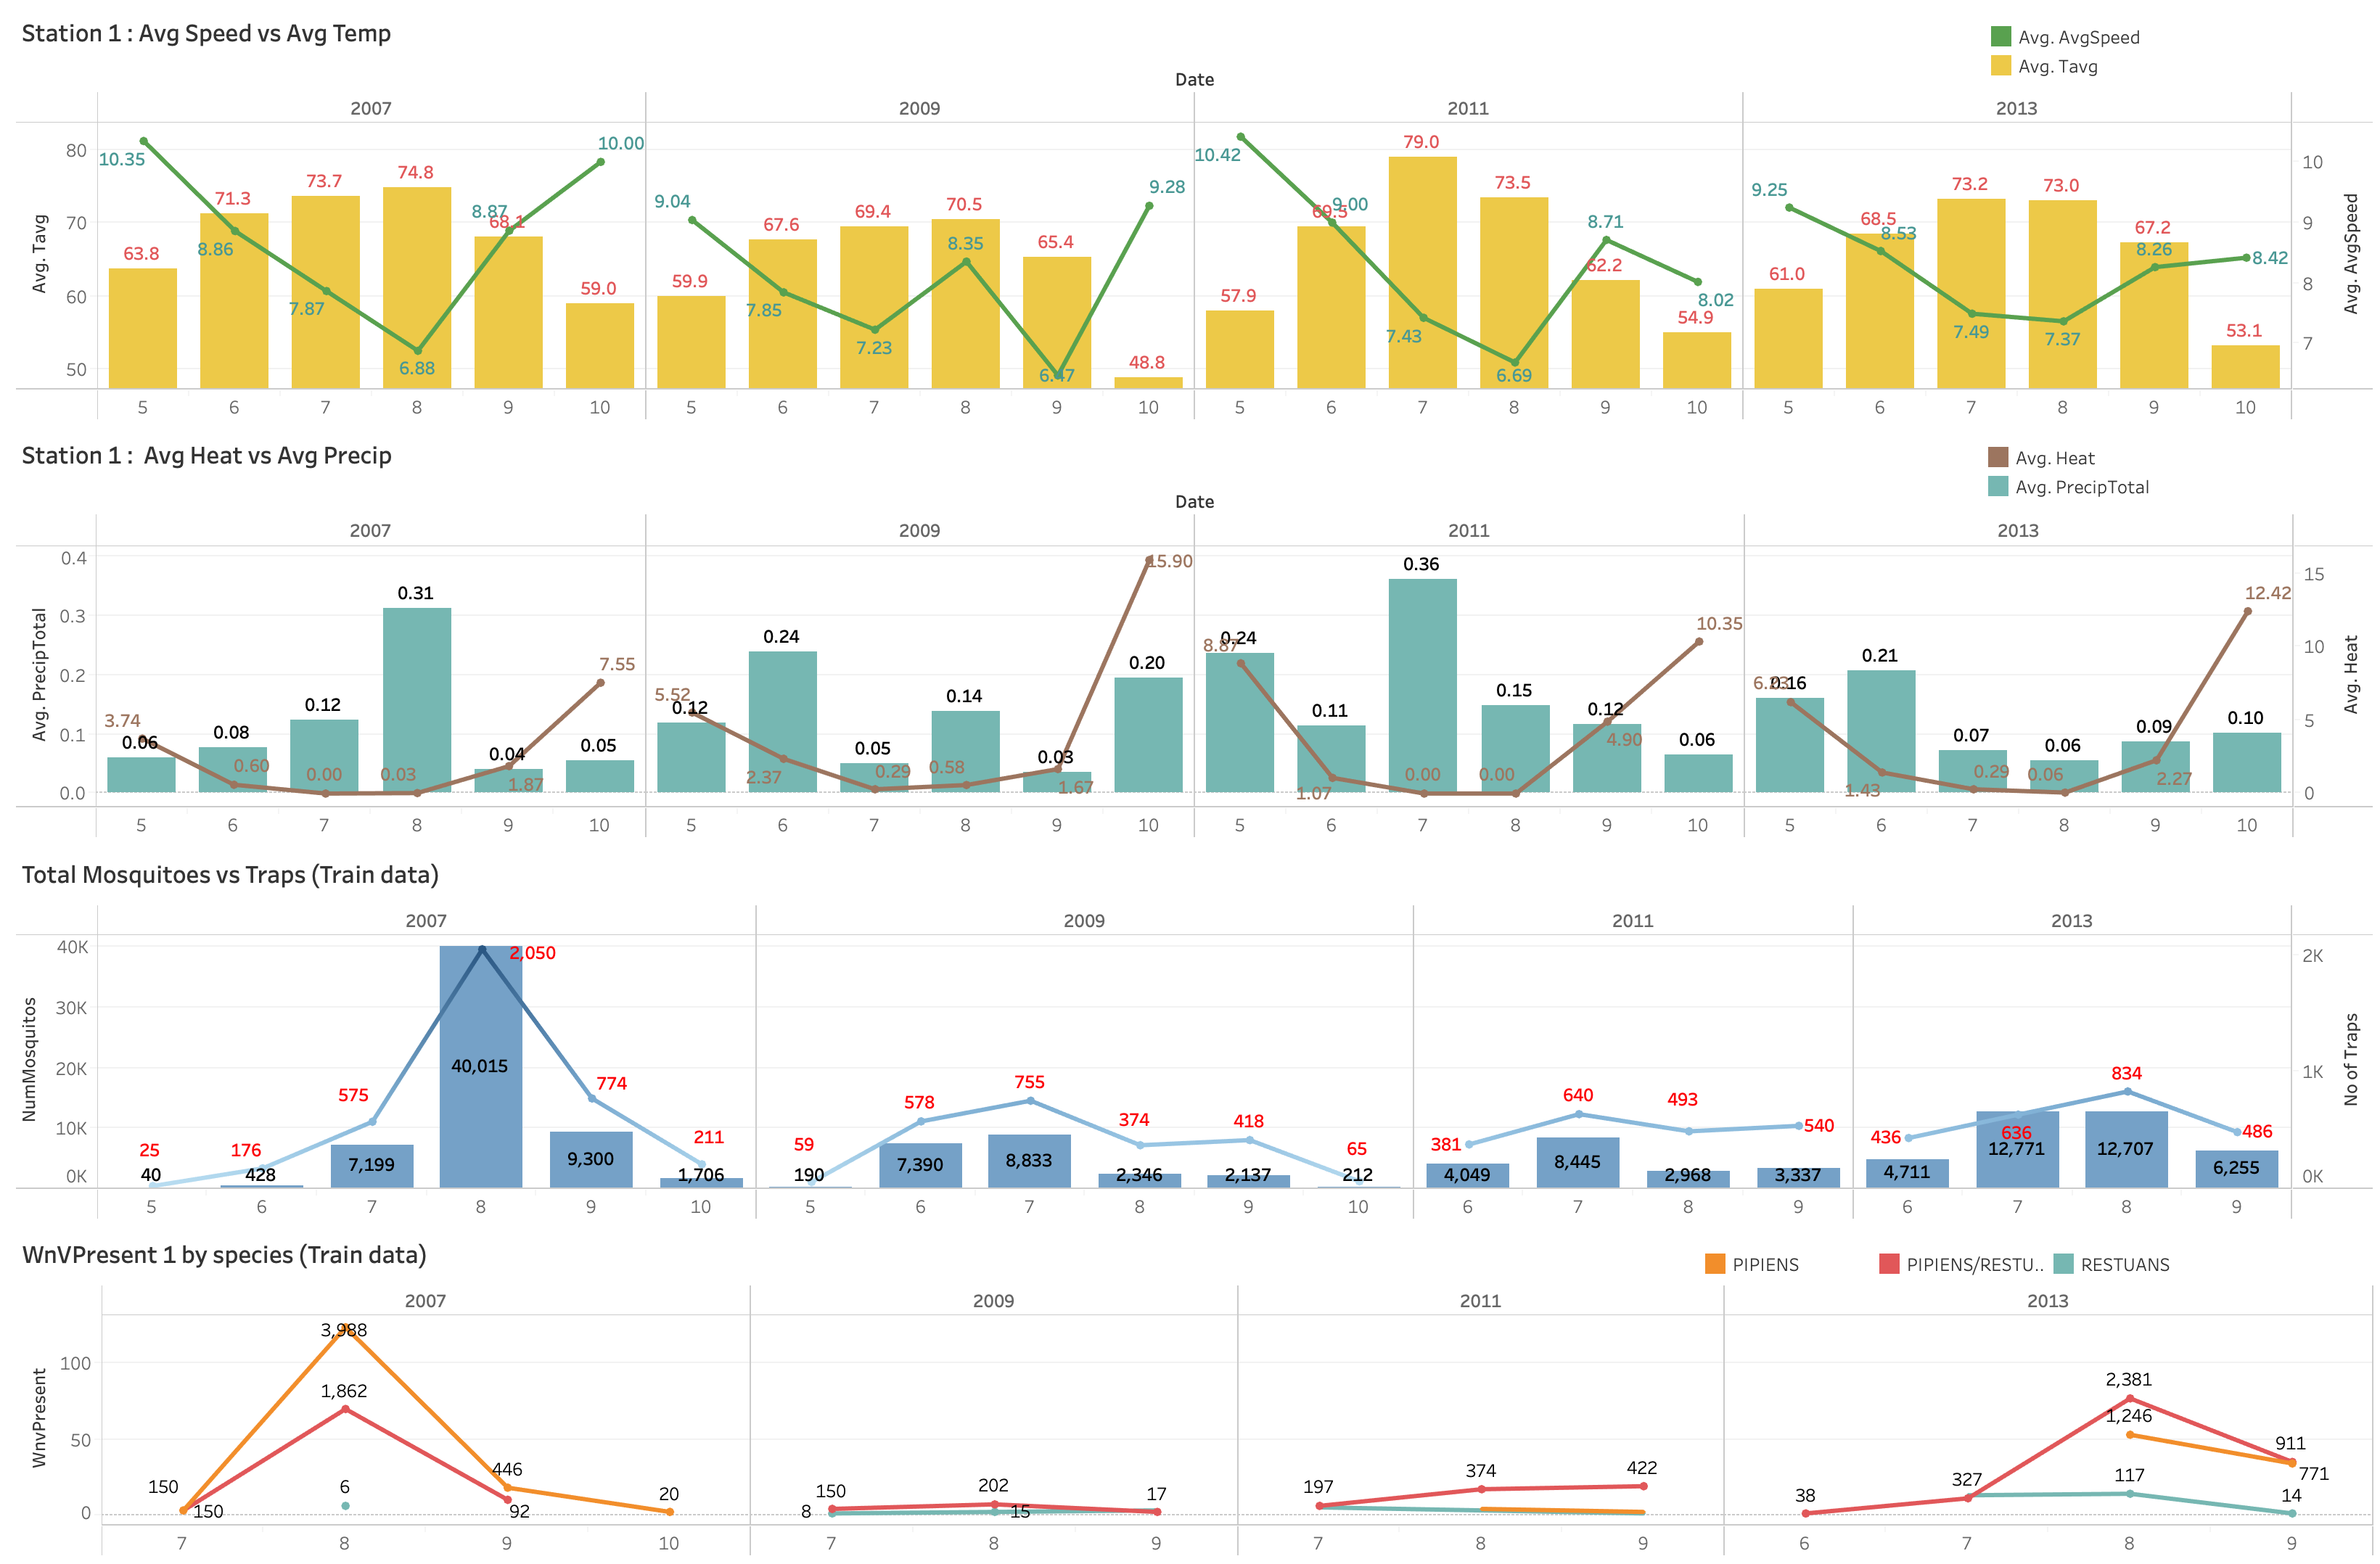

In [70]:
from IPython.display import Image
Image(filename="/content/drive/My Drive/DSI14 p4/assets/EDA-Tableau/Overview.png")


##### Observation: 
###### 1) There is a negative correlation between the wind speed and Avg Temp, the precipitation level and the no. of mosquitoes. 

2) Mosquitoes seem to breed faster in conditions where wind speed is low and both precipitation level + average temp are high.

3) The traps were deployed seasonally and the numbers tend to build up between Jul to Sep for the observed period.

In [71]:
from IPython.display import HTML
from base64 import b64encode
#mp4 = open('/content/Mosquitoes cluster.mp4','rb').read()

mp4 = open('/content/drive/My Drive/DSI14 p4/assets/Mosquitoes cluster.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=1000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

## Strategic Trap Placements

In [72]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/drive/My Drive/DSI14 p4/assets/Traps.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=1000 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

#### Observation: 
###### 1) The mosquitoes clusters had moved from Southern area to the Northern area from the period 2007 to 2013 period. 
2) The presence of the WnV is also correlated to the mosquitoes cluster. 

3) We see that the traps are also more placed in a more strategic manner over the years.

## Spray

In [73]:
spray1 = pd.read_csv('/content/drive/My Drive/DSI14 p4/assets/spray.csv', parse_dates=['Date'])
spray1[['Latitude','Longitude']]=round(spray1[['Latitude','Longitude']],2)
spray_group=spray1.groupby(['Date','Latitude','Longitude']).count()
spray_group.reset_index(inplace=True)
spray_group.rename(columns={'Time':'No_of_sprays'},inplace=True)

# Plotting the scatterplot
import plotly.express as px
fig = px.scatter(spray_group, x='Latitude', y='Longitude',color=pd.to_datetime(spray_group['Date']).dt.year, size='No_of_sprays', 
                 title="Spray Data by Location")


fig1 = px.scatter(spray_group, x='Date', y='Longitude',color='No_of_sprays', size='No_of_sprays',
                 title="Spray Data by Period")

fig1.update_xaxes(
    rangeslider_visible=True,
    tickformatstops = [
        dict(dtickrange=[None, 1000], value="%H:%M:%S.%L ms"),
        dict(dtickrange=[1000, 60000], value="%H:%M:%S s"),
        dict(dtickrange=[60000, 3600000], value="%H:%M m"),
        dict(dtickrange=[3600000, 86400000], value="%H:%M h"),
        dict(dtickrange=[86400000, 604800000], value="%e. %b d"),
        dict(dtickrange=[604800000, "M1"], value="%e. %b w"),
        dict(dtickrange=["M1", "M12"], value="%b '%y M"),
        dict(dtickrange=["M12", None], value="%Y Y")
    ]
)

fig.show()
fig1.show()

The spray locations based on the spray data correspond to spray cluster feature 1 and 3 generated previously.

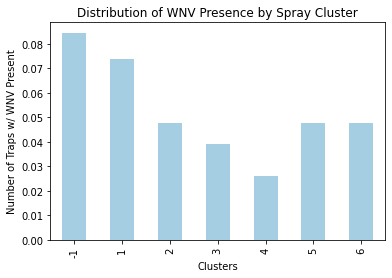

In [74]:

ax2 = train_weather.groupby(by='spray_cluster')['WnvPresent'].mean().plot(kind='bar', 
                                                             colormap='Paired', 
                                                             title='Distribution of WNV Presence by Spray Cluster')
ax2.set_xlabel('Clusters')
ax2.set_ylabel('Number of Traps w/ WNV Present');

## Hotspots 

By identifying clusters with higher probabilities of WNV presence, distance features 'dist_from_ohare' and 'dist_from_doty' are created to calculate the proximity to each hotspot respectively. 

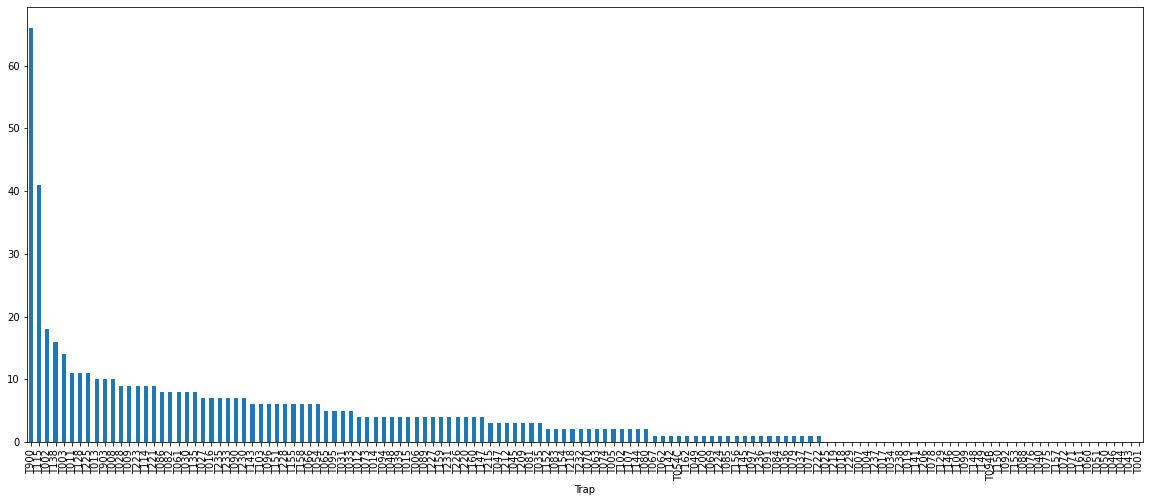

In [75]:
# Traps like T900 (Ohare Airport) and T115 (Doty) have higher prevalence of wnv
plt.figure(figsize=(20,8))
train_weather.groupby('Trap')['WnvPresent'].sum().sort_values(ascending=False).plot(kind='bar');

In [0]:
# Create distance feature from the two hotspots, Ohare Airport and Doty

ohare_airport_coord = (41.974689, -87.890615) # lat, lon
doty_coord = (41.673408, -87.599862)

train_weather['coordinates'] = list(zip(train_weather['Latitude'], train_weather['Longitude']))

train_weather['dist_from_ohare'] = [geopy.distance.distance(ohare_airport_coord, x).km for x in zip(train_weather['coordinates'])]
train_weather['dist_from_doty'] = [geopy.distance.distance(doty_coord, x).km for x in zip(train_weather['coordinates'])]

## Prevalence of WNV By Species

The prevalence of WNV amongst the species *culex pipiens*, *culex pipiens/restuans* and *culex restuans* is evident.

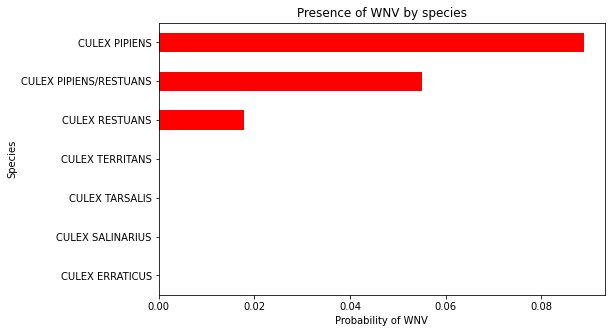

In [77]:
# WNV seems to be more prevalent among Pipiens, Pipiens/Restuans and Restuans
plt.figure(figsize=(8,5))
train_weather.groupby('Species')['WnvPresent'].mean().sort_values().plot(kind='barh', color='red')
plt.title('Presence of WNV by species')
plt.xlabel('Probability of WNV');

In [0]:
train_by_species=pd.DataFrame(train_weather.groupby(['Date','Species'])['WnvPresent'].mean()).reset_index()

In [79]:

fig = px.line(train_by_species, x='Date', y='WnvPresent',title='WnV Present By Species',color='Species')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

In [0]:
# One hot encode mosquito species
train_weather = pd.get_dummies(train_weather, columns=['Species'], drop_first=True)

In [0]:
# Drop species that are not at risk of carrying WNV
train_weather = train_weather.drop(columns=['Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS'], axis=1)

# Prepare Train and Test Set

## Prepare train set

In [0]:
# Drop the following columns as we have engineering features from these. As NumMosquitos is not in our test set we will leave it out from our training set
cols_to_drop = ['Date', 'Street', 'Trap', 'NumMosquitos', 'Station', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'coordinates']

train_weather = train_weather.drop(cols_to_drop, axis=1)

In [0]:
# Convert all columns to lowercase and replace spaces with underscores
train_weather.columns = [x.lower().replace(' ','_') for x in train_weather.columns]

In [84]:
train_weather.columns

Index(['latitude', 'longitude', 'wnvpresent', 'day', 'week', 'month', 'year',
       'day_length', 'heavy_rain_last_14_days_count',
       'light_rain_last_14_days_count', 'tmax_rolling_14', 'tmin_rolling_14',
       'tavg_rolling_14', 'depart_rolling_14', 'dewpoint_rolling_14',
       'wetbulb_rolling_14', 'heat_rolling_14', 'cool_rolling_14',
       'preciptotal_rolling_14', 'stnpressure_rolling_14',
       'sealevel_rolling_14', 'resultspeed_rolling_14', 'resultdir_rolling_14',
       'avgspeed_rolling_14', 'day_length_rolling_14', 'spray_cluster',
       'dist_from_ohare', 'dist_from_doty', 'species_culex_pipiens',
       'species_culex_pipiens/restuans', 'species_culex_restuans'],
      dtype='object')

In [85]:
# Check that there are no null values in the training set
train_weather.isnull().sum().sum()

0

In [0]:
# Save final training set as clean_train_weather.csv
train_weather.to_csv('/content/drive/My Drive/DSI14 p4/assets/clean_train_weather.csv', index=False)

## Prepare test set

In [0]:
# Breakdown the Date into day, week, month and year
test['day'] = test['Date'].dt.dayofyear
test['week'] = test['Date'].dt.week
test['month'] = test['Date'].dt.month
test['year'] = test['Date'].dt.year

# Merge the test and weather dataframes on the Date column
test_weather = pd.merge(test, weather, on='Date')

# Add spray clusters to model the possible spray areas in the test set
test_weather = add_clusters(test_weather)

# Create coordinates for each location
test_weather['coordinates'] = list(zip(test_weather['Latitude'], test_weather['Longitude']))

# Create distance feature from the two hotspots, Ohare Airport and Doty
test_weather['dist_from_ohare'] = [geopy.distance.distance(ohare_airport_coord, x).km for x in zip(test_weather['coordinates'])]
test_weather['dist_from_doty'] = [geopy.distance.distance(doty_coord, x).km for x in zip(test_weather['coordinates'])]

# One hot encode mosquito species
test_weather = pd.get_dummies(test_weather,columns=['Species'],drop_first=True)

# Drop species that are not at risk of carrying WNV
test_weather = test_weather.drop(columns=['Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'Species_UNSPECIFIED CULEX'], axis=1)

# Drop test_weather columns that are not in train_weather
cols_to_drop = ['Date', 'Address', 'Block', 'Street', 'Trap','AddressNumberAndStreet', 'AddressAccuracy',
                'Station', 'Tmax', 'Tmin', 'Tavg','Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
                'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'coordinates']
test_weather = test_weather.drop(cols_to_drop, axis=1)

In [0]:
# Convert all columns to lowercase and replace spaces with underscores
test_weather.columns = [x.lower().replace(' ','_') for x in test_weather.columns]

In [89]:
# Sense check all columns
test_weather.columns

Index(['id', 'latitude', 'longitude', 'day', 'week', 'month', 'year',
       'day_length', 'heavy_rain_last_14_days_count',
       'light_rain_last_14_days_count', 'tmax_rolling_14', 'tmin_rolling_14',
       'tavg_rolling_14', 'depart_rolling_14', 'dewpoint_rolling_14',
       'wetbulb_rolling_14', 'heat_rolling_14', 'cool_rolling_14',
       'preciptotal_rolling_14', 'stnpressure_rolling_14',
       'sealevel_rolling_14', 'resultspeed_rolling_14', 'resultdir_rolling_14',
       'avgspeed_rolling_14', 'day_length_rolling_14', 'spray_cluster',
       'dist_from_ohare', 'dist_from_doty', 'species_culex_pipiens',
       'species_culex_pipiens/restuans', 'species_culex_restuans'],
      dtype='object')

In [90]:
# Check that no features were missed out 
# Test set contains an additional column for 'id' while the training set contains 'wnvpresent'
print(test_weather.columns.difference(train_weather.columns))
print(train_weather.columns.difference(test_weather.columns))

Index(['id'], dtype='object')
Index(['wnvpresent'], dtype='object')


In [91]:
# Check that there are no null values in the test set
test_weather.isnull().sum().sum()

0

In [0]:
# Save final test_weather file as clean_test.csv
test_weather.to_csv('/content/drive/My Drive/DSI14 p4/assets/clean_test.csv', index=False)

# Split notebook here

# Problem Statement

# Executive Summary

# Contents

# Import Libraries

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import plotly.express as px # conda install -c plotly plotly
import geopy.distance # Install geopy using 'conda install -c conda-forge geopy'
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



# Load Data

In [0]:
# Read in clean training set
df = pd.read_csv('/content/drive/My Drive/DSI14 p4/assets/clean_train_weather.csv')

In [95]:
df.shape

(10506, 31)

In [96]:
# View first 5 rows of df
df.head()

,latitude,longitude,wnvpresent,day,week,month,year,day_length,heavy_rain_last_14_days_count,light_rain_last_14_days_count,tmax_rolling_14,tmin_rolling_14,tavg_rolling_14,depart_rolling_14,dewpoint_rolling_14,wetbulb_rolling_14,heat_rolling_14,cool_rolling_14,preciptotal_rolling_14,stnpressure_rolling_14,sealevel_rolling_14,resultspeed_rolling_14,resultdir_rolling_14,avgspeed_rolling_14,day_length_rolling_14,spray_cluster,dist_from_ohare,dist_from_doty,species_culex_pipiens,species_culex_pipiens/restuans,species_culex_restuans
0,41.954690,-87.800991,0,149,22,5,2007,1496,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,7.754490,35.430907,0,1,0
1,41.954690,-87.800991,0,149,22,5,2007,1496,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,7.754490,35.430907,0,0,1
2,41.994991,-87.769279,0,149,22,5,2007,1496,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,10.304920,38.390522,0,0,1
3,41.974089,-87.824812,0,149,22,5,2007,1496,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,5.454421,38.270018,0,1,0
4,41.974089,-87.824812,0,149,22,5,2007,1496,2.0,2.0,76.357143,51.571429,64.142857,2.928571,45.285714,54.142857,3.714286,2.857143,0.092143,29.402143,30.124286,8.214286,16.928571,9.85,1486.071429,1,5.454421,38.270018,0,0,1


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        10506 non-null  float64
 1   longitude                       10506 non-null  float64
 2   wnvpresent                      10506 non-null  int64  
 3   day                             10506 non-null  int64  
 4   week                            10506 non-null  int64  
 5   month                           10506 non-null  int64  
 6   year                            10506 non-null  int64  
 7   day_length                      10506 non-null  int64  
 8   heavy_rain_last_14_days_count   10506 non-null  float64
 9   light_rain_last_14_days_count   10506 non-null  float64
 10  tmax_rolling_14                 10506 non-null  float64
 11  tmin_rolling_14                 10506 non-null  float64
 12  tavg_rolling_14                 

In [98]:
# No null values
df.isnull().sum().sum()

0

# Modeling

In [0]:
# Assign features to X and target variable to y
X = df[[col for col in df.columns if col != 'wnvpresent']]
y = df['wnvpresent']

In [0]:
# Perform a train_test_split to create a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [101]:
# Check X_train shape
X_train.shape

(8404, 30)

In [102]:
# Check y_train shape
y_train.shape

(8404,)

In [103]:
# Check X_val shape
X_val.shape

(2102, 30)

In [104]:
# Check y_val shape
y_val.shape

(2102,)

Stratification ensured that our train_test_split method returns training and validation sets that have the same proportion of class labels as the input dataset.

In [105]:
# Check split in class labels for y_train
y_train.value_counts(normalize=True)

0    0.947525
1    0.052475
Name: wnvpresent, dtype: float64

In [106]:
# Check split in class labels for y_val
y_val.value_counts(normalize=True)

0    0.947669
1    0.052331
Name: wnvpresent, dtype: float64

We will be running a couple of classification models to predict the presence of WNV based on the given features. The production model chosen will be based on the highest ROC AUC score on the train and validation sets. Our **baseline score will be an ROC AUC score of 0.5**, meaning that the baseline model has no class separation capacity.

In [0]:
# Write a function that takes in the actual y value and model predictions, 
# and prints out the confusion matrix and classification report

def cmat(actual_y, predictions):
    # Create a confusion matrix
    cm = confusion_matrix(actual_y, predictions)
    cm_df = pd.DataFrame(cm, columns=['Predicted WNV Absent','Predicted WNV Present'], index=['Actual WNV Absent', 'Actual WNV Present'])
    print(cm_df)
    print('--------------------------------------------------------------')
    # Create a classification report
    print(classification_report(actual_y, predictions))

## Handling Imbalanced Classes

In [0]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
      plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



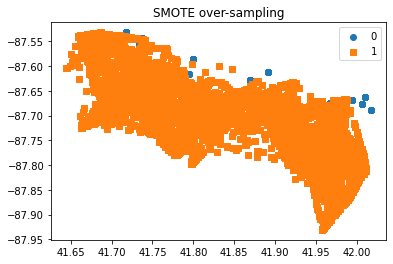

In [142]:
# To update: include SMOTE plot here
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling');

In [0]:
# Remind reader that we will select model based on ROC AUC

## Logistic Regression

Logistic regression is one of the most commonly used methods for binary classification problems. We will apply logistic regression here to predict the probability of WNV presence.

In [111]:
%%time

# Create a pipeline
pipe_lr = make_pipeline(SMOTE(random_state=42),
                        StandardScaler(), # Scale features
                        LogisticRegression(random_state=42, tol=1000))

# Search over the following values of hyperparameters:
pipe_lr_params = {
    'logisticregression__C' : [0.5,0.75,1], # Regularization
    'logisticregression__max_iter' : [1000] 
}

# Instantiate GridSearchCV
gs_lr = GridSearchCV(pipe_lr,
                     param_grid=pipe_lr_params,
                     cv=5,
                     scoring='roc_auc')

# Fit model on training data
gs_lr.fit(X_train, y_train)

# Generate predictions on validation set
lr_pred = gs_lr.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_lr.best_params_)
print('Best CV ROC AUC score: ', gs_lr.best_score_)
print('Training ROC AUC score:', gs_lr.score(X_train, y_train))
print('Validation ROC AUC score:', gs_lr.score(X_val, y_val))
print('            ')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

Best parameters:  {'logisticregression__C': 0.75, 'logisticregression__max_iter': 1000}
Best CV ROC AUC score:  0.803168514832517
Training ROC AUC score: 0.8086035954839887
Validation ROC AUC score: 0.7694231471339905
            
CPU times: user 1.8 s, sys: 1.17 s, total: 2.97 s
Wall time: 1.6 s


In [112]:
# Confusion matrix and classification report for Logistic Regression
cmat(actual_y=y_val, predictions=lr_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1337                    655
Actual WNV Present                    28                     82
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1992
           1       0.11      0.75      0.19       110

    accuracy                           0.68      2102
   macro avg       0.55      0.71      0.50      2102
weighted avg       0.93      0.68      0.76      2102



## SGD Classifier

SGD Classifier implements regularised linear models with Stochastic Gradient Descent. We will instantiate the SGDClassifier using loss='log' to implement the logistic regression and compare its performance to the previous model.

In [113]:
%%time

# Create a pipeline
pipe_sgd = make_pipeline(SMOTE(random_state=42), 
                         StandardScaler(), # Scale features
                         SGDClassifier(loss='log', max_iter=1000, random_state=42))

# Search over the following values of hyperparameters:
pipe_sgd_params = {
    'sgdclassifier__penalty': ['l1','l2'],
    'sgdclassifier__alpha': [.01,.1]
}

# Instantiate GridSearchCV
gs_sgd = GridSearchCV(pipe_sgd,
                      param_grid=pipe_sgd_params,
                      cv=5,
                      scoring='roc_auc')

# Fit model on training data
gs_sgd.fit(X_train, y_train)

# Generate predictions on validation set
sgd_pred = gs_sgd.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_sgd.best_params_)
print('Best CV ROC AUC score: ', gs_sgd.best_score_)
print('Training ROC AUC score:', gs_sgd.score(X_train, y_train))
print('Validation ROC AUC score:', gs_sgd.score(X_val, y_val))
print('            ')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

Best parameters:  {'sgdclassifier__alpha': 0.01, 'sgdclassifier__penalty': 'l2'}
Best CV ROC AUC score:  0.8312685135418768
Training ROC AUC score: 0.8394193040772757
Validation ROC AUC score: 0.811820007301935
            
CPU times: user 3.07 s, sys: 1.94 s, total: 5.01 s
Wall time: 2.78 s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [114]:
# Confusion matrix and classification report for SGD Classifier
cmat(actual_y=y_val, predictions=sgd_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1455                    537
Actual WNV Present                    23                     87
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1992
           1       0.14      0.79      0.24       110

    accuracy                           0.73      2102
   macro avg       0.56      0.76      0.54      2102
weighted avg       0.94      0.73      0.81      2102



## Bagging Classifier

As decision trees tend to overfit on the training data, we will use bagged decision trees instead. Bagging is an ensemble method that conducts random resampling with replacement to create multiple models and aggregates the predictions.

In [115]:
%%time

# Create a pipeline
pipe_bag = make_pipeline(SMOTE(random_state=42),
                         BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))

# Search over the following values of hyperparameters:
pipe_bag_params = {
    'baggingclassifier__n_estimators' : [100],
    'baggingclassifier__base_estimator__max_depth' : [2,3]
}

# Instantiate GridSearchCV
gs_bag = GridSearchCV(pipe_bag,
                      param_grid=pipe_bag_params,
                      cv=5,
                      scoring='roc_auc')

# Fit model on training data
gs_bag.fit(X_train, y_train)

# Generate predictions on validation set
bag_pred = gs_bag.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_bag.best_params_)
print('Best CV ROC AUC score: ', gs_bag.best_score_)
print('Training ROC AUC score:', gs_bag.score(X_train, y_train))
print('Validation ROC AUC score:', gs_bag.score(X_val, y_val))
print('            ')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

Best parameters:  {'baggingclassifier__base_estimator__max_depth': 3, 'baggingclassifier__n_estimators': 100}
Best CV ROC AUC score:  0.7828645604302494
Training ROC AUC score: 0.7973616923851042
Validation ROC AUC score: 0.7665320372398685
            
CPU times: user 32.4 s, sys: 122 ms, total: 32.6 s
Wall time: 32.5 s


In [116]:
# Confusion matrix and classification report for Bagging Classifier
cmat(actual_y=y_val, predictions=bag_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1275                    717
Actual WNV Present                    17                     93
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.64      0.78      1992
           1       0.11      0.85      0.20       110

    accuracy                           0.65      2102
   macro avg       0.55      0.74      0.49      2102
weighted avg       0.94      0.65      0.75      2102



## Random Forest Classifier

With bagged decision trees, we generate many trees on very similar data ie if a certain seasonality feature is a strong predictor of WNV, each bagged tree node will be simliar. These trees will thus be very strongly corelated with one another. Random forest will be useful in 'de-correlating' our trees. This is done by selecting a random subset of features at each node.

In [117]:
%%time

# Create a pipeline
# Handle imbalanced class by setting class_weight='balanced' in random forest
pipe_rf = make_pipeline(RandomForestClassifier(class_weight='balanced', random_state=42))

# Search over the following values of hyperparameters:
pipe_rf_params = {
    'randomforestclassifier__n_estimators': [100,150],
    'randomforestclassifier__max_depth': [2,3]
}

# Instantiate GridSearchCV
gs_rf = GridSearchCV(pipe_rf,
                      param_grid=pipe_rf_params,
                      cv=5,
                      scoring='roc_auc')

# Fit model on training data
gs_rf.fit(X_train, y_train)

# Generate predictions on validation set
rf_pred = gs_rf.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_rf.best_params_)
print('Best CV ROC AUC score: ', gs_rf.best_score_)
print('Training ROC AUC score:', gs_rf.score(X_train, y_train))
print('Validation ROC AUC score:', gs_rf.score(X_val, y_val))
print('            ')

Best parameters:  {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 150}
Best CV ROC AUC score:  0.8255279080456821
Training ROC AUC score: 0.8371280949903508
Validation ROC AUC score: 0.805565443592552
            
CPU times: user 9.19 s, sys: 23 ms, total: 9.21 s
Wall time: 9.22 s


In [118]:
# Confusion matrix and classification report for Random Forest
cmat(actual_y=y_val, predictions=rf_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1298                    694
Actual WNV Present                    22                     88
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1992
           1       0.11      0.80      0.20       110

    accuracy                           0.66      2102
   macro avg       0.55      0.73      0.49      2102
weighted avg       0.94      0.66      0.75      2102



## AdaBoost Classifer

AdaBoost is a boosting ensemble method that fits a sequence of weak learners on modified versions of the data. AdaBoost works by putting more weight on misclassifications and less on those already handled well. This allows it to convert a set of weak classifiers into a strong one.

In [119]:
%%time

# Create a pipeline
pipe_adaboost = make_pipeline(SMOTE(random_state=42),
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))

# Search over the following values of hyperparameters:
pipe_adaboost_params = {
    'adaboostclassifier__learning_rate': [0.9,1], #0.1
    'adaboostclassifier__n_estimators': [100], #150
    'adaboostclassifier__base_estimator__max_depth': [1] #2 
}

# Instantiate GridSearchCV
gs_adaboost = GridSearchCV(pipe_adaboost,
                          param_grid=pipe_adaboost_params,
                          cv=5,
                          scoring='roc_auc')

# Fit model on training data
gs_adaboost.fit(X_train, y_train)

# Generate predictions on validation set
adaboost_pred = gs_adaboost.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_adaboost.best_params_)
print('Best CV ROC AUC score: ', gs_adaboost.best_score_)
print('Training ROC AUC score:', gs_adaboost.score(X_train, y_train))
print('Validation ROC AUC score:', gs_adaboost.score(X_val, y_val))
print('            ')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

Best parameters:  {'adaboostclassifier__base_estimator__max_depth': 1, 'adaboostclassifier__learning_rate': 0.9, 'adaboostclassifier__n_estimators': 100}
Best CV ROC AUC score:  0.8258371139628427
Training ROC AUC score: 0.8548929387988609
Validation ROC AUC score: 0.7982680722891566
            
CPU times: user 25 s, sys: 68.7 ms, total: 25.1 s
Wall time: 25.1 s


In [120]:
# Confusion matrix and classification report for AdaBoost
cmat(actual_y=y_val, predictions=adaboost_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1723                    269
Actual WNV Present                    56                     54
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1992
           1       0.17      0.49      0.25       110

    accuracy                           0.85      2102
   macro avg       0.57      0.68      0.58      2102
weighted avg       0.93      0.85      0.88      2102



## Gradient Boosting Classifier

While the AdaBoost model identifies the shortcomings by using high weight data points, gradient boosting performs the same by using gradients in the loss function.

In [121]:
%%time

# Create a pipeline
pipe_gb = make_pipeline(SMOTE(random_state=42),
                        GradientBoostingClassifier(random_state=42))

# Search over the following values of hyperparameters:
pipe_gb_params = {
    'gradientboostingclassifier__max_depth': [2,3],
    'gradientboostingclassifier__n_estimators': [100], #150
    'gradientboostingclassifier__learning_rate': [0.1] 
}

# Instantiate GridSearchCV
gs_gb = GridSearchCV(pipe_gb,
                     param_grid= pipe_gb_params,
                     cv=5,
                     scoring='roc_auc')

# Fit model on training data
gs_gb.fit(X_train, y_train)

# Generate predictions on validation set
gb_pred = gs_gb.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_gb.best_params_)
print('Best CV ROC AUC score: ', gs_gb.best_score_)
print('Training ROC AUC score:', gs_gb.score(X_train, y_train))
print('Validation ROC AUC score:', gs_gb.score(X_val, y_val))
print('            ')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.2

Best parameters:  {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 2, 'gradientboostingclassifier__n_estimators': 100}
Best CV ROC AUC score:  0.8309582405628287
Training ROC AUC score: 0.8570992882899738
Validation ROC AUC score: 0.8124383899233298
            
CPU times: user 42.9 s, sys: 15.7 ms, total: 42.9 s
Wall time: 42.9 s


In [122]:
# Confusion matrix and classification report for Gradient Boost
cmat(actual_y=y_val, predictions=gb_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1733                    259
Actual WNV Present                    51                     59
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1992
           1       0.19      0.54      0.28       110

    accuracy                           0.85      2102
   macro avg       0.58      0.70      0.60      2102
weighted avg       0.93      0.85      0.88      2102



## XGBoost Classifier

XGBoost (eXtreme Gradient Boosting) is a decision-tree-based ensemble technique that uses a gradient boosting algorithm. Some key benefits of XGBoost includes the ability to regularize to reduce overfitting and its fast computational speed. The 'scale_pos_weight' hyperparameter helps to handle our imbalanced class. The recommended weight to use is the ratio of the number of negative class to the positive class.

In [123]:
# 7963 obs in negative class and 441 obs in positive class
y_train.value_counts()

0    7963
1     441
Name: wnvpresent, dtype: int64

In [124]:
%%time

# Create a pipeline
pipe_xgb = make_pipeline(XGBClassifier(random_state=42))

# Search over the following values of hyperparameters:
pipe_xgb_params = {
    'xgbclassifier__eval_metric' : ['auc'],
    'xgbclassifier__subsample' : [0.5], # Randomly sample 0.5 of the data to prevent overfitting
    'xgbclassifier__colsample_bytree' : [0.5], 
    'xgbclassifier__learning_rate' : [0.1], #0.5
    'xgbclassifier__max_depth' : [2, 3], #5
    'xgbclassifier__scale_pos_weight': [7963/441], # Ratio of negative class to positive class
    'xgbclassifier__n_estimators' : [100], #500
    'xgbclassifier__reg_alpha' : [100], # L1 regularization term on weight #0, 1, 50, 75
    'xgbclassifier__reg_lambda' : [100], # L2 regularization term on weights #0, 1, 2, 50,75
    'xgbclassifier__gamma' : [0.1], # Gamma specifies the minimum loss reduction required to make a split #.2
    'xgbclassifier__objective' : ['binary:logistic']
}

# Instantiate GridSearchCV
gs_xgb = GridSearchCV(pipe_xgb,
                      param_grid=pipe_xgb_params,
                      cv=5,
                      scoring='roc_auc')

# Fit model on training data
gs_xgb.fit(X_train, y_train)

# Generate predictions on validation set
xgb_pred = gs_xgb.predict(X_val)

# Print best parameters and ROC AUC scores
print('Best parameters: ', gs_xgb.best_params_)
print('Best CV ROC AUC score: ', gs_xgb.best_score_)
print('Training ROC AUC score:', gs_xgb.score(X_train, y_train))
print('Validation ROC AUC score:', gs_xgb.score(X_val, y_val))
print('            ')

Best parameters:  {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__eval_metric': 'auc', 'xgbclassifier__gamma': 0.1, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__reg_alpha': 100, 'xgbclassifier__reg_lambda': 100, 'xgbclassifier__scale_pos_weight': 18.05668934240363, 'xgbclassifier__subsample': 0.5}
Best CV ROC AUC score:  0.8380804164632956
Training ROC AUC score: 0.8598841353277047
Validation ROC AUC score: 0.8244523548740416
            
CPU times: user 5.45 s, sys: 18.9 ms, total: 5.47 s
Wall time: 5.57 s


In [125]:
# Confusion matrix and classification report for XGBoost
cmat(actual_y=y_val, predictions=xgb_pred)

                    Predicted WNV Absent  Predicted WNV Present
Actual WNV Absent                   1493                    499
Actual WNV Present                    25                     85
--------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1992
           1       0.15      0.77      0.24       110

    accuracy                           0.75      2102
   macro avg       0.56      0.76      0.55      2102
weighted avg       0.94      0.75      0.82      2102



The first iteration of XGBoost without tuning gave an ROC AUC score of 0.99 on the train set and 0.82 on the validation set, indicating a serious overfit. However, after some tuning and regularization, the model is now less overfitted, achieving an ROC AUC score of 0.86 on the train set and 0.83 on the validation set. The model also performs decently well on recall, being able to correctly predict 79% of the actual WNV cases. The XGBoost model has good class separation capacity. As it outperforms all the other models on ROC AUC, we will use this as our final production model.

# Model Evaluation

## Summary Metrics

|                    | Logistic Regression | SGD  | Bagging | Random Forest | AdaBoost | Gradient Boost | XGBoost |
|--------------------|---------------------|------|---------|---------------|----------|----------------|---------|
| Training ROC AUC   | 0.81                | 0.82 | 0.77    | 0.84          | 0.84     | 0.87           | 0.86    |
| Validation ROC AUC | 0.77                | 0.79 | 0.75    | 0.81          | 0.79     | 0.80           | **0.83**    |
| Recall             | 0.72                | 0.57 | 0.83    | 0.80          | 0.55     | 0.54           | 0.79    |

Write a short summary of the models done

In [0]:
# Function to plot ROC curve with AUC
def plot_roc(model, X, actual_y, title):
    
    # Calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X)
    preds = probs[:,1]
    
    fpr, tpr, threshold = roc_curve(actual_y, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(7,5))
    plt.title(title +': ROC Curve with AUC = ' + '%0.2f' % roc_auc, fontsize=12, fontweight='bold')
    plt.plot(fpr, tpr, 'b', label='ROC Curve') # Plot the ROC curve
    plt.plot([0, 1], [0, 1],'r--', label='Baseline') # Plot baseline 
    plt.legend(loc = 'lower right')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');

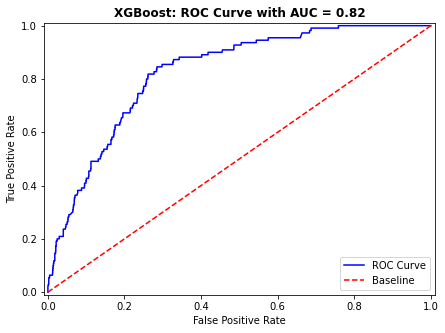

In [127]:
# Plot the ROC curve for XGBoost
plot_roc(model = gs_xgb, 
         X = X_val,
         actual_y = y_val,
         title = "XGBoost")

XGBoost classifier performed the best based on ROC AUC score, attaining 0.83 on the validation set.

In [0]:
# Find feature importance for XGBoost
feature_importance = gs_xgb.best_estimator_.named_steps["xgbclassifier"].feature_importances_

# Save feature importance to a dataframe
features_df = pd.DataFrame(index=X_train.columns, data = feature_importance, columns=['feature_importance'])

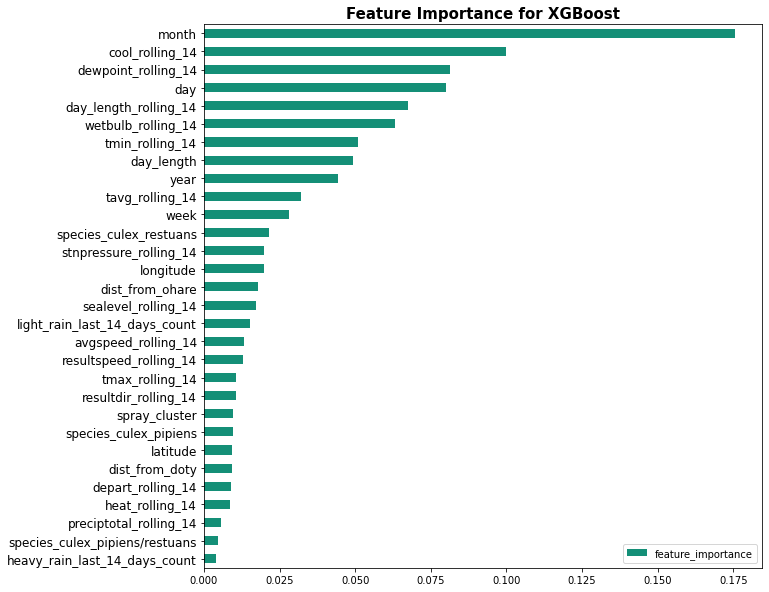

In [129]:
# Barplot for feature importance
features_df.sort_values(by='feature_importance', ascending=True).plot(kind='barh', figsize=(10,10), color='#148F77')
plt.title('Feature Importance for XGBoost', fontsize=15, weight='bold')
plt.yticks(fontsize=12);

Month is the most important predictor of WNV presence. Seasonality plays a very key role in mosquito breeding and the spread of WNV, with other features like week and day being within the top 5 most important features. This is possibly due the fact that these features capture a blend of weather conditions that are ideal for WNV. Rolling weather features over a 14-day period like wetbulb, dewpoint, minimum temperature and result speed were also key predictors. Location features like longitude was also useful in predicting possible hotspots, while spray cluster helped to identify the possible areas that were sprayed on to combat the WNV outbreak.

# Scoring on Kaggle

In [0]:
# Read in clean test set
test = pd.read_csv('/content/drive/My Drive/DSI14 p4/assets/clean_test.csv')

In [0]:
X_test = test[[col for col in test.columns if col != 'id']]

In [0]:
# Generate predictions on test set
y_predict = gs_xgb.predict_proba(X_test)

In [0]:
# Create a dataframe for our predictions
result = pd.DataFrame(test['id'])

In [0]:
# Rename the column as per the sample file requirements
result.rename(columns={'id': 'Id'}, inplace=True)

In [0]:
# Probability of WNV presence 
result['WnvPresent'] = y_predict[:,1]

In [0]:
# Save predictions in result.csv and submit on Kaggle
result.to_csv('/content/drive/My Drive/DSI14 p4/assets/result.csv', index=False)

Kaggle private and public score: 0.76

# Cost Benefit Analysis

The West Nile Virus was detected in the United States since 1999.

A research by Loren Barber,Jerome Schleier and Robert Peterson <sup>3</sup> assessed the financial cost of the 2005 West Nile Virus disease outbreak in Sacramento County, California, and evaluated the decrease in WNV disease needed to mitigate the cost of emergency aerial spray response. The West Nile Virus infection can be asymptomatic or symptomatic in humans, with a 4:1 proportion. The disease can be mild, causing flu-like side effects (as in West Nile fever [WNF]), or severe, affecting the central nervous system symptom (as in West Nile neuroinvasive disease [WNND]).

Using this case study of 163 cases from Sacramento County in 2005 with a total of 117 (71.8%) were diagnosed as WNF and 46 (28.2%) as WNND, the total calculated negative economic impact was roughly `$`2.9 Million inclusive of treatments and economic losses, far surpassing the expenses of emergency aerial spray response of `$`700k. The actual number of disease cases prevented by the emergency spray is uncertain. But Carney et al. and Elnaiem et al. did providee evidence of the effectiveness of the 2005 spray by showing a reduction both in mosquito populations and WNV disease cases in humans. Zero cases were reported in spray area and 18 cases outside. Even though these are pure estimation via sampling, the cost analysis suggest that only 15 WNND cases prevention is needed for the benefits of the spray response to exceed the expense of the virus. 


Although this estimation of the medical costs and the true number of cases prevented by the emergency spray are uncertain, it is likely that the true cost of the virus is higher than estimated. Pain, mental health costs, and ecological risks associated with the emergency spray is not included. There have been debate that the use of pesticides to slow the virus caused mass death of lobsters in 1999<sup>4 </sup>.

Alternative method of solution may be vaccination. However, research analysis suggests that universal vaccination against the West Nile Virus <sup>5</sup> would unlikely result in societal monetary savings unless disease incidence increases drastically. Hence, spraying is still the best method to reduce soceity impact at the moment until true ecological cost for the use of pesticide to kill the mosquitos are taken into account.

Spraying at areas with more than 15 WNND suggests the most cost effective solution.

# Conclusion and Recommendations

# Sources

<sup>1</sup> https://www.kaggle.com/c/predict-west-nile-virus/overview <br/>
<sup>2</sup> https://www.mosquito.org/page/lifecycle<br/>
<sup>3</sup> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3322011/<br/>
<sup>4 </sup> https://www.nytimes.com/2002/08/11/nyregion/mosquito-control-weighing-costs-versus-benefits.html<br/>
<sup>5 </sup> https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3291438/